# Do the types of crimes committed in Chicago depend on location and time?

## Preparing the data

Let's import the libraries we will be using:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import pingouin

Let's first read in the data:

In [2]:
df = pd.read_csv('data/chicago_crime_data.csv', dtype={'ID': object, 'beat_num': object})
df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11192233,JB100016,12/31/17 23:58,046XX N ST LOUIS AVE,630,BURGLARY,ATTEMPT FORCIBLE ENTRY,APARTMENT,False,False,...,33.0,14,5,1152214.0,1930694.0,2017,5/4/18 15:51,41.965694,-87.715726,"(41.965693651, -87.715726125)"
1,11196379,JB105867,12/31/17 23:50,024XX N LAKE SHORE DR NB,460,BATTERY,SIMPLE,MOVIE HOUSE/THEATER,False,False,...,43.0,7,08B,1175293.0,1916610.0,2017,5/4/18 15:51,41.926559,-87.631294,"(41.926558908, -87.631294073)"
2,11192540,JB100551,12/31/17 23:48,001XX E SUPERIOR ST,890,THEFT,FROM BUILDING,HOTEL/MOTEL,False,False,...,42.0,8,6,1177508.0,1905401.0,2017,5/4/18 15:51,41.895751,-87.623496,"(41.895750913, -87.623495923)"
3,11192239,JB100032,12/31/17 23:45,019XX S CANAL ST,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,True,...,25.0,31,14,1173432.0,1891037.0,2017,5/4/18 15:51,41.856427,-87.638893,"(41.856426716, -87.638892854)"
4,11192254,JB100003,12/31/17 23:45,115XX S STATE ST,041A,BATTERY,AGGRAVATED: HANDGUN,RESIDENCE,False,True,...,34.0,53,04B,1178329.0,1828012.0,2017,5/4/18 15:51,41.683369,-87.622830,"(41.683369303, -87.622829524)"


As you can see, there are *many* categories in the `Primary Type` and `Location Description` columns:

In [3]:
df["Primary Type"].drop_duplicates()

0                                  BURGLARY
1                                   BATTERY
2                                     THEFT
3                           CRIMINAL DAMAGE
5                                 NARCOTICS
7                             OTHER OFFENSE
9                        DECEPTIVE PRACTICE
12                        WEAPONS VIOLATION
16                                  ASSAULT
18                        CRIMINAL TRESPASS
20                   PUBLIC PEACE VIOLATION
29                      CRIM SEXUAL ASSAULT
49                      MOTOR VEHICLE THEFT
65                                  ROBBERY
110              OFFENSE INVOLVING CHILDREN
135        INTERFERENCE WITH PUBLIC OFFICER
139                    LIQUOR LAW VIOLATION
331                                STALKING
397                              KIDNAPPING
496                                   ARSON
561                             SEX OFFENSE
985       CONCEALED CARRY LICENSE VIOLATION
1301                           I

In [4]:
df["Location Description"].drop_duplicates()

0                   APARTMENT
1         MOVIE HOUSE/THEATER
2                 HOTEL/MOTEL
3                      STREET
4                   RESIDENCE
                 ...         
148447              VESTIBULE
150685                GANGWAY
190713            CHA HALLWAY
193432           NURSING HOME
233178                   CLUB
Name: Location Description, Length: 128, dtype: object

So let's group them into wider categories to make our analysis easier. For that, we will use these two dictionaries that we prepared beforehand:

In [5]:
dict_Locations = {'AIRPORT TERMINAL UPPER LEVEL - NON-SECURE AREA': 'Airport & Related',
 'AIRPORT EXTERIOR - SECURE AREA': 'Airport & Related',
 'AIRCRAFT': 'Airport & Related',
 'AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA': 'Airport & Related',
 'AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA': 'Airport & Related',
 'AIRPORT TERMINAL UPPER LEVEL - SECURE AREA': 'Airport & Related',
 'AIRPORT PARKING LOT': 'Airport & Related',
 'AIRPORT BUILDING NON-TERMINAL - SECURE AREA': 'Airport & Related',
 'AIRPORT TERMINAL LOWER LEVEL - SECURE AREA': 'Airport & Related',
 'AIRPORT TERMINAL MEZZANINE - NON-SECURE AREA': 'Airport & Related',
 'AIRPORT TRANSPORTATION SYSTEM (ATS)': 'Airport & Related',
 'AIRPORT VENDING ESTABLISHMENT': 'Airport & Related',
 'AIRPORT/AIRCRAFT': 'Airport & Related',
 'AIRPORT EXTERIOR - NON-SECURE AREA': 'Airport & Related',
 'HOSPITAL BUILDING/GROUNDS': 'Hospitals & Related',
 'MEDICAL/DENTAL OFFICE': 'Hospitals & Related',
 'NURSING HOME': 'Hospitals & Related',
 'ANIMAL HOSPITAL': 'Hospitals & Related',
 'NURSING HOME/RETIREMENT HOME': 'Hospitals & Related',
 'STAIRWELL': 'Residential & Related',
 'DRIVEWAY - RESIDENTIAL': 'Residential & Related',
 'RESIDENCE-GARAGE': 'Residential & Related',
 'HOUSE': 'Residential & Related',
 'PORCH': 'Residential & Related',
 'CHA HALLWAY': 'Residential & Related',
 'CHA APARTMENT': 'Residential & Related',
 'BASEMENT': 'Residential & Related',
 'CHA PARKING LOT/GROUNDS': 'Residential & Related',
 'RESIDENCE PORCH/HALLWAY': 'Residential & Related',
 'APARTMENT': 'Residential & Related',
 'GARAGE': 'Residential & Related',
 'RESIDENCE': 'Residential & Related',
 'ROOMING HOUSE': 'Residential & Related',
 'CHA HALLWAY/STAIRWELL/ELEVATOR': 'Residential & Related',
 'HOTEL/MOTEL': 'Residential & Related',
 'CHA PARKING LOT': 'Residential & Related',
 'RESIDENTIAL YARD (FRONT/BACK)': 'Residential & Related',
 'COLLEGE/UNIVERSITY RESIDENCE HALL': 'Colleges & Related',
 'SCHOOL, PUBLIC, GROUNDS': 'Colleges & Related',
 'SCHOOL, PRIVATE, GROUNDS': 'Colleges & Related',
 'SCHOOL YARD': 'Colleges & Related',
 'DAY CARE CENTER': 'Colleges & Related',
 'COLLEGE/UNIVERSITY GROUNDS': 'Colleges & Related',
 'SCHOOL, PUBLIC, BUILDING': 'Colleges & Related',
 'SCHOOL, PRIVATE, BUILDING': 'Colleges & Related',
 'JAIL / LOCK-UP FACILITY': 'Goverment Buildings & Related',
 'GOVERNMENT BUILDING/PROPERTY': 'Goverment Buildings & Related',
 'POLICE FACILITY/VEH PARKING LOT': 'Goverment Buildings & Related',
 'FIRE STATION': 'Goverment Buildings & Related',
 'PARK PROPERTY': 'Goverment Buildings & Related',
 'FEDERAL BUILDING': 'Goverment Buildings & Related',
 'FOREST PRESERVE': 'Goverment Buildings & Related',
 'LIBRARY': 'Goverment Buildings & Related',
 'TAVERN/LIQUOR STORE': 'Liquor Stores & Related',
 'CLUB': 'Liquor Stores & Related',
 'TAVERN': 'Liquor Stores & Related',
 'POOL ROOM': 'Liquor Stores & Related',
 'BAR OR TAVERN': 'Liquor Stores & Related',
 'ATHLETIC CLUB': 'Stores & Related',
 'BARBERSHOP': 'Stores & Related',
 'CONVENIENCE STORE': 'Stores & Related',
 'SMALL RETAIL STORE': 'Stores & Related',
 'RESTAURANT': 'Stores & Related',
 'DRUG STORE': 'Stores & Related',
 'FACTORY/MANUFACTURING BUILDING': 'Stores & Related',
 'MOVIE HOUSE/THEATER': 'Stores & Related',
 'RETAIL STORE': 'Stores & Related',
 'PARKING LOT': 'Stores & Related',
 'DEPARTMENT STORE': 'Stores & Related',
 'GAS STATION': 'Stores & Related',
 'VESTIBULE': 'Stores & Related',
 'CAR WASH': 'Stores & Related',
 'CLEANING STORE': 'Stores & Related',
 'GAS STATION DRIVE/PROP.': 'Stores & Related',
 'NEWSSTAND': 'Stores & Related',
 'COIN OPERATED MACHINE': 'Stores & Related',
 'APPLIANCE STORE': 'Stores & Related',
 'COMMERCIAL / BUSINESS OFFICE': 'Stores & Related',
 'BOWLING ALLEY': 'Stores & Related',
 'GROCERY FOOD STORE': 'Stores & Related',
 'GANGWAY': 'Vehicles & Related',
 'VEHICLE - DELIVERY TRUCK': 'Vehicles & Related',
 'BOAT/WATERCRAFT': 'Vehicles & Related',
 'TAXICAB': 'Vehicles & Related',
 'VEHICLE-COMMERCIAL': 'Vehicles & Related',
 'OTHER COMMERCIAL TRANSPORTATION': 'Vehicles & Related',
 'AUTO': 'Vehicles & Related',
 'AUTO / BOAT / RV DEALERSHIP': 'Vehicles & Related',
 'VEHICLE - OTHER RIDE SERVICE': 'Vehicles & Related',
 'VEHICLE NON-COMMERCIAL': 'Vehicles & Related',
 'VEHICLE - OTHER RIDE SHARE SERVICE (E.G., UBER, LYFT)': 'Vehicles & Related',
 'CTA BUS': 'Public Transport & Related',
 'CTA TRAIN': 'Public Transport & Related',
 'OTHER RAILROAD PROP / TRAIN DEPOT': 'Public Transport & Related',
 'CTA BUS STOP': 'Public Transport & Related',
 'CTA PROPERTY': 'Public Transport & Related',
 'CTA STATION': 'Public Transport & Related',
 'CTA PLATFORM': 'Public Transport & Related',
 'CTA "L" PLATFORM': 'Public Transport & Related',
 'CTA GARAGE / OTHER PROPERTY': 'Public Transport & Related',
 'CTA TRACKS - RIGHT OF WAY': 'Public Transport & Related',
 'ALLEY': 'Street & Related',
 'BRIDGE': 'Street & Related',
 'CEMETARY': 'Street & Related',
 'CHURCH': 'Street & Related',
 'SIDEWALK': 'Street & Related',
 'HALLWAY': 'Street & Related',
 'ABANDONED BUILDING': 'Street & Related',
 'SPORTS ARENA/STADIUM': 'Street & Related',
 'CONSTRUCTION SITE': 'Street & Related',
 'DRIVEWAY': 'Street & Related',
 'YARD': 'Street & Related',
 'VACANT LOT': 'Street & Related',
 'STREET': 'Street & Related',
 'LAKEFRONT/WATERFRONT/RIVERBANK': 'Street & Related',
 'CHURCH/SYNAGOGUE/PLACE OF WORSHIP': 'Street & Related',
 'HIGHWAY/EXPRESSWAY': 'Street & Related',
 'VACANT LOT/LAND': 'Street & Related',
 'PARKING LOT/GARAGE(NON.RESID.)': 'Street & Related',
 'CREDIT UNION': 'Bank & Related',
 'CURRENCY EXCHANGE': 'Bank & Related',
 'PAWN SHOP': 'Bank & Related',
 'RIVER BANK': 'Bank & Related',
 'SAVINGS AND LOAN': 'Bank & Related',
 'WAREHOUSE': 'Bank & Related',
 'ATM (AUTOMATIC TELLER MACHINE)': 'Bank & Related',
 'BANK': 'Bank & Related',
 'OTHER': 'Other Locations'}

dict_Offenses = {'CRIMINAL TRESPASS': 'Theft Related',
 'MOTOR VEHICLE THEFT': 'Theft Related',
 'BURGLARY': 'Theft Related',
 'ROBBERY': 'Theft Related',
 'THEFT': 'Theft Related',
 'ARSON': 'Property Damage',
 'CRIMINAL DAMAGE': 'Property Damage',
 'HOMICIDE': 'Violence & Related',
 'KIDNAPPING': 'Violence & Related',
 'ASSAULT': 'Violence & Related',
 'BATTERY': 'Violence & Related',
 'OFFENSE INVOLVING CHILDREN': 'Sexual Offenses & Related',
 'SEX OFFENSE': 'Sexual Offenses & Related',
 'HUMAN TRAFFICKING': 'Sexual Offenses & Related',
 'PROSTITUTION': 'Sexual Offenses & Related',
 'CRIM SEXUAL ASSAULT': 'Sexual Offenses & Related',
 'PUBLIC INDECENCY': 'Sexual Offenses & Related',
 'OBSCENITY': 'Sexual Offenses & Related',
 'STALKING': 'Sexual Offenses & Related',
 'INTIMIDATION': 'Dangerous practices',
 'INTERFERENCE WITH PUBLIC OFFICER': 'Dangerous practices',
 'WEAPONS VIOLATION': 'Dangerous practices',
 'CONCEALED CARRY LICENSE VIOLATION': 'Dangerous practices',
 'DECEPTIVE PRACTICE': 'Dangerous practices',
 'LIQUOR LAW VIOLATION': 'Substances & Related',
 'GAMBLING': 'Substances & Related',
 'OTHER NARCOTIC VIOLATION': 'Substances & Related',
 'NARCOTICS': 'Substances & Related',
 'OTHER OFFENSE': 'Other Offenses',
 'PUBLIC PEACE VIOLATIONNON-CRIMINAL': 'Other Offenses',
 'NON-CRIMINAL (SUBJECT SPECIFIED)': 'Other Offenses'}

Now it's simply a matter of creating the new columns and replacing the values:

In [6]:
df["Offenses_cat"]=df["Primary Type"].replace(dict_Offenses)
df["Location_cat"]=df["Location Description"].replace(dict_Locations)

df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Offenses_cat,Location_cat
0,11192233,JB100016,12/31/17 23:58,046XX N ST LOUIS AVE,630,BURGLARY,ATTEMPT FORCIBLE ENTRY,APARTMENT,False,False,...,5,1152214.0,1930694.0,2017,5/4/18 15:51,41.965694,-87.715726,"(41.965693651, -87.715726125)",Theft Related,Residential & Related
1,11196379,JB105867,12/31/17 23:50,024XX N LAKE SHORE DR NB,460,BATTERY,SIMPLE,MOVIE HOUSE/THEATER,False,False,...,08B,1175293.0,1916610.0,2017,5/4/18 15:51,41.926559,-87.631294,"(41.926558908, -87.631294073)",Violence & Related,Stores & Related
2,11192540,JB100551,12/31/17 23:48,001XX E SUPERIOR ST,890,THEFT,FROM BUILDING,HOTEL/MOTEL,False,False,...,6,1177508.0,1905401.0,2017,5/4/18 15:51,41.895751,-87.623496,"(41.895750913, -87.623495923)",Theft Related,Residential & Related
3,11192239,JB100032,12/31/17 23:45,019XX S CANAL ST,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,True,...,14,1173432.0,1891037.0,2017,5/4/18 15:51,41.856427,-87.638893,"(41.856426716, -87.638892854)",Property Damage,Street & Related
4,11192254,JB100003,12/31/17 23:45,115XX S STATE ST,041A,BATTERY,AGGRAVATED: HANDGUN,RESIDENCE,False,True,...,04B,1178329.0,1828012.0,2017,5/4/18 15:51,41.683369,-87.622830,"(41.683369303, -87.622829524)",Violence & Related,Residential & Related


## `pandas`'s `crosstab()` function

To make contingency tables in `pandas`, we use the [**`crosstab()`**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html) function. You simply specify which Series will be the rows of the table (`index` argument) and which Series will be the columns (`columns` argument), like this:

In [7]:
my_contingency_table = pd.crosstab(index=df["Offenses_cat"], columns=df["Location_cat"])
my_contingency_table

Location_cat,Airport & Related,Bank & Related,Colleges & Related,Goverment Buildings & Related,Hospitals & Related,Liquor Stores & Related,Other Locations,Public Transport & Related,Residential & Related,Stores & Related,Street & Related,Vehicles & Related
Offenses_cat,,,,,,,,,,,,
Dangerous practices,252,1536,179,206,142,226,2331,439,9460,3312,5409,582
NON-CRIMINAL,4,1,0,3,1,1,3,1,13,0,8,2
Other Offenses,60,25,252,230,150,48,1355,36,9555,831,4431,264
PUBLIC PEACE VIOLATION,26,1,137,53,19,4,47,36,258,82,827,8
Property Damage,34,117,334,274,111,99,816,543,12147,1665,12644,703
Sexual Offenses & Related,9,6,280,131,149,33,241,101,3429,112,1363,119
Substances & Related,60,7,190,692,97,107,149,163,1889,360,7707,631
Theft Related,620,521,1221,1377,731,1272,4605,2714,28834,21194,41780,2564
Violence & Related,180,122,2984,1022,917,766,1780,1297,32103,4246,22964,1006


Notice how the `concat()` function outputs *counts* by default. We can make it show *percentages* with the `normalize` argument. You can normalize in one of two ways:

1. taking the sum of each column and dividing the respective column values by that sum (`normalize="columns"`); or
2. taking the sum of each row and dividing all the respective row values by that sum (`normalize="index"`)

This diagram illustrates the difference:

![](data/images/crosstab_normalize_explanation.jpg)

### Example 1

Produce a contingency table in which the values are the percentage of offenses in a particular location that were of a specific crime type.

**Answer.** Shown below:

In [8]:
pd.crosstab(index=df["Offenses_cat"], columns=df["Location_cat"], normalize="columns")*100

Location_cat,Airport & Related,Bank & Related,Colleges & Related,Goverment Buildings & Related,Hospitals & Related,Liquor Stores & Related,Other Locations,Public Transport & Related,Residential & Related,Stores & Related,Street & Related,Vehicles & Related
Offenses_cat,,,,,,,,,,,,
Dangerous practices,20.240964,65.753425,3.209611,5.165496,6.128615,8.841941,20.579147,8.236398,9.683892,10.414439,5.568653,9.899643
NON-CRIMINAL,0.321285,0.042808,0.000000,0.075226,0.043159,0.039124,0.026485,0.018762,0.013308,0.000000,0.008236,0.034019
Other Offenses,4.819277,1.070205,4.518558,5.767302,6.473889,1.877934,11.962567,0.675422,9.781140,2.613043,4.561786,4.490560
PUBLIC PEACE VIOLATION,2.088353,0.042808,2.456518,1.328987,0.820026,0.156495,0.414938,0.675422,0.264106,0.257845,0.851410,0.136078
Property Damage,2.730924,5.008562,5.988883,6.870612,4.790678,3.873239,7.204026,10.187617,12.434485,5.235520,13.017203,11.957816
Sexual Offenses & Related,0.722892,0.256849,5.020620,3.284855,6.430729,1.291080,2.127660,1.894934,3.510155,0.352179,1.403231,2.024154
Substances & Related,4.819277,0.299658,3.406850,17.352056,4.186448,4.186228,1.315441,3.058161,1.933707,1.132004,7.934482,10.733118
Theft Related,49.799197,22.303082,21.893491,34.528586,31.549417,49.765258,40.655072,50.919325,29.516420,66.643607,43.013188,43.612859
Violence & Related,14.457831,5.222603,53.505469,25.626881,39.577039,29.968701,15.714664,24.333959,32.862788,13.351362,23.641811,17.111754


Note that we multiplied the entire table by 100 to make the percentages easier to read (since they are given as decimals rather than percentages by default).

In this table, you can see that of all the offenses that happened in airports, 20.24% were of the type "Dangerous practices".

### Exercise 1

Produce a contingency table in which the values are the percentage of offenses of a particular type that occurred in a particular location. Looking only at offenses of type "Property Damage", what is the most common location where this type of offense occurred, and what is its relative frequency?

**Answer.**

-------

One good way of visualizing contingency tables is with heat maps. To make heat maps like the ones we saw during lecture, we can use the [`sns.heatmap()`](https://seaborn.pydata.org/generated/seaborn.heatmap.html) function. Keeping the defaults, this is what we get:

<AxesSubplot:xlabel='Location_cat', ylabel='Offenses_cat'>

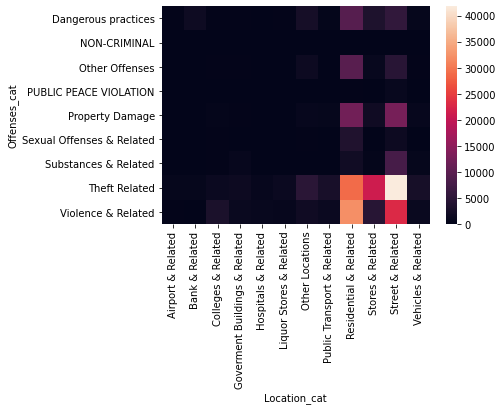

In [9]:
sns.heatmap(my_contingency_table)

To make it more legible, let's change the color palette. There are [many](https://medium.com/@morganjonesartist/color-guide-to-seaborn-palettes-da849406d44f) available, but we will stick to the `Reds` palette:

<AxesSubplot:xlabel='Location_cat', ylabel='Offenses_cat'>

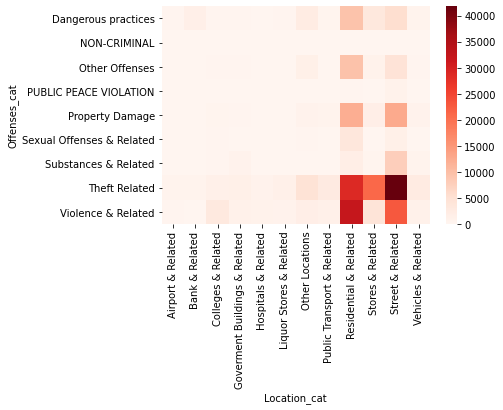

In [10]:
sns.heatmap(my_contingency_table, cmap="Reds")

You can add a title by tweaking the code slightly (to see all the options available, check the [documentation](https://seaborn.pydata.org/generated/seaborn.heatmap.html)):

Text(0.5, 1.0, 'Primary type vs. Location description (counts)')

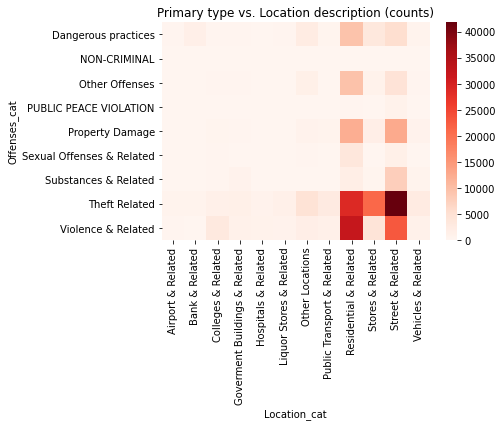

In [11]:
ax = sns.heatmap(my_contingency_table, cmap="Reds")
ax.set_title("Primary type vs. Location description (counts)")

### Exercise 2

Make a heat map of the normalized contingency table you created in Exercise 1.

**Answer.**

-------

## Executing hypothesis tests

In the last few cases, we have introduced the intuition behind the hypothesis testing framework. We learned that we can use the $t$ - test to compare the mean of a sample with another value (to determine if there is a statistically significant difference between them). We also saw how we can extend this logic with the $\chi^2$-test to decide if two categorical variables are independent of each other or not. Here, we will show you how to conduct both types of tests using the `pingouin` and `scipy` Python libraries.

### The $t$ - test with `pingouin`

The `pingouin` library makes it very easy to run $t$ - tests with the [**`ttest()`**](https://pingouin-stats.org/generated/pingouin.ttest.html) function. You simply need to pass the sample data and the value to compare with as arguments. For instance, let's say that we wanted to compare the mean of dataset `A` (below) with the value 56. Are the two numbers statistically different? The code we would use would be the following (note that we imported `pinguoin` at the start of this notebook):

In [12]:
# Importing dataset A, which is a Series of integers
A = pd.read_csv("data/A.csv")

# Here, A["A"] is the Series, our sample (its mean is 39.6, and the sample size is 244)
# And 56 is the value to compare with
pingouin.ttest(A["A"], 56)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-13.153916,243,two-sided,3.348320e-30,"[37.11, 42.03]",0.842093,9.248e+26,1.0


As you can see from the output, since the $p$ - value is essentially zero, we can reject the null hypothesis. The output also tells us that the test was two-sided (see the `tail` column).

In the case that you have two samples whose means you want to compare (a two-sample $t$ - test), the syntax is almost identical, with the only difference being that instead of providing a number as the comparison point, you provide the second dataset:

In [13]:
# Importing dataset B, which is another Series of integers
B = pd.read_csv("data/B.csv")

# Here, B["B"] is the second Series (its mean is 37.15, and the sample size is 215)
pingouin.ttest(A["A"],  B["B"])

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,1.296085,445.251887,two-sided,0.195618,"[-1.25, 6.07]",0.121509,0.234,0.254013


The output shows that there is not enough evidence to reject the null hypothesis at a significance level of 0.05. In other words, the means of samples `A` and `B` are statistically indistinguishable.

### Exercise 3

Conduct a two-sample $t$ test between the `A` and `C` datasets:

In [14]:
# Importing dataset C, which is another Series of integers
C = pd.read_csv("data/C.csv")

**Answer.**

-------

### The $\chi^2$ - test with `scipy`

Running chi-squared tests is quite easy in Python using the `scipy` library. If you have a look at the top of this notebook, you will see that we imported the [**`chi2_contingency()`**](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html) function from this library using this code:

~~~python
from scipy.stats import chi2_contingency
~~~

The only thing we have to do now is call the `chi2_contingency()` function and pass the relevant contingency table (not normalized) as the argument:

In [ ]:
chi2_contingency(my_contingency_table)

The $p$ - value is the second number in the output. Therefore, to only show the $p$-value, we can index the output like this:

In [ ]:
chi2_contingency(my_contingency_table)[1]

### Exercise 4

This is a subset of the dataset in which we only included the offenses that are violent crimes with locations in residential areas:

In [ ]:
subset_df = df[
    (df['Location_cat'] == 'Residential & Related') &
    (df['Offenses_cat'] == 'Violence & Related')
]
subset_df

Make a contingency table of `Location Description` versus `Primary Type` using this smaller dataset, plot it as a heat map, and report the $p$ - value of a $\chi^2$ test.

**Answer.**

-------

## Discretizing time to make it categorical

We can make use of the date and time methods that `pandas` provides to discretize time. Let's first convert the `Date` column to the native `pandas` `datetime` data type:

In [15]:
df["date_reformatted"] = pd.to_datetime(df["Date"]) # This line might take several seconds to run
df["date_reformatted"].head()

0   2017-12-31 23:58:00
1   2017-12-31 23:50:00
2   2017-12-31 23:48:00
3   2017-12-31 23:45:00
4   2017-12-31 23:45:00
Name: date_reformatted, dtype: datetime64[ns]

Now we can access the day of the week of each record using the `dt` accessor and the `dayofweek` attribute (for an exhaustive list of attributes, see the [docs](https://pandas.pydata.org/docs/reference/series.html#datetimelike-properties)). Monday is indexed as day `0`, and Sunday is `6`:

In [ ]:
df["day_of_week"] = df["date_reformatted"].dt.dayofweek
df["day_of_week"].head()

Finally, we can create our contingency table as usual:

In [ ]:
pd.crosstab(df['Offenses_cat'], df['day_of_week'])

### Exercise 5

We suspect that throughout the course of a typical day, the distribution of crime locations may shift materially. We ask you to:

1. Extract the time of the day from the `date_reformatted` column we created in the previous section (**Hint:** For this, use the `dt` accessor and the `hour` attribute)
2. Make a contingency table
3. Plot the contingency table as a heatmap
4. Conduct a $\chi^2$-test and report the $p$-value

**Answer.**

-------

## Attribution

"Crimes - 2001 to Present", March 5, 2021, Chicago Police Department, dataset licensed under the City of Chicago [Terms of Use](https://www.chicago.gov/city/en/narr/foia/data_disclaimer.html), https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2